In [1]:
"""
This file contained the feature-based similarity search method using two-layer neural network

Created by Zexi Chen(zchen22)
Date: Oct 2, 2016
"""

import numpy
import six.moves.cPickle as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from ConvLayer import ConvLayer
from helper import loadData, dtw, euclideanDist
%matplotlib inline

In [2]:
# read the data and rescale to 0-1
# samples* is a dataset with 10000 time series sampled from original images(2001 image and 2006 image) randomly
train_set = loadData('../theano/data/samples1')
valid_set = loadData('../theano/data/samples2')
test_set = loadData('../theano/data/samples3')

In [3]:
def makePairs(dataset, numInstance):
    # pick numInstance pairs of time series at random from the training set    
    sampleIndices = numpy.random.choice(dataset.shape[0], 2 * numInstance)
    data_set_samples = numpy.zeros((2 * numInstance, dataset.shape[1]),dtype=numpy.float32)
    for i in range(numInstance * 2):
        data_set_samples[i] = dataset[sampleIndices[i]]
    
    data_set_reshape = numpy.reshape(data_set_samples, (data_set_samples.shape[0]/2, data_set_samples.shape[1]*2))
    data_set1 = data_set_reshape/255.0
    data_dtws = numpy.zeros((data_set1.shape[0],1), dtype=numpy.float32)
    for i in range(data_set1.shape[0]):
        data_dtws[i,0] = dtw(data_set1[i,0:23], data_set1[i,23:])**2
    
    return data_set1, data_dtws

In [4]:
# shuffle, make pairs of time series,and calculate pair-wise dtw 
valid_set1, valid_dtws = makePairs(valid_set, valid_set.shape[0])
test_set1, test_dtws = makePairs(test_set, test_set.shape[0])

In [5]:
# build the neural network model
# start the tensorflow interaction interface
sess = tf.InteractiveSession()

In [6]:
n_hiddens = [200,100,50]
learning_rate = [1e-2]
training_iter = 10000

# create two variable placehold, x for the training features, 
# y for the labels(in this model it is the dtw distance between two time series)
x = tf.placeholder(tf.float32, shape=[None, train_set.shape[1]*2])
y = tf.placeholder(tf.float32, shape=[None, 1])

layer1 = ConvLayer(
    None,
    None,
    input = x,
    activation = tf.nn.sigmoid,
    n_visible = train_set.shape[1]*2,
    n_hidden =  n_hiddens[0]
)

layer2 = ConvLayer(
    None,
    None,
    input = layer1.output,
    activation = tf.nn.sigmoid,
    n_visible = n_hiddens[0]*2,
    n_hidden = n_hiddens[1]
)

layer3 = ConvLayer(
    None,
    None,
    input = layer2.output,
    activation = tf.nn.sigmoid,
    n_visible = n_hiddens[1]*2,
    n_hidden = n_hiddens[2]
)

In [7]:
# compute the cost and minimize it
cost = layer3.cost_function(y)
train_step = tf.train.AdamOptimizer(learning_rate[0]).minimize(cost)

sess.run(tf.initialize_all_variables())

In [8]:
# run the model
train_error = []
valid_error = []
best_valid_error = numpy.inf
numInstance = 1000
train_iter_error = []
for i in range(training_iter):
    sample_train_set, sample_train_dtws = makePairs(train_set, numInstance)
    space_holder, train_err = sess.run([train_step, cost], feed_dict={x:sample_train_set, y:sample_train_dtws})
    train_iter_error.append(train_err)
    if i%100 == 0:
        train_error.append(numpy.mean(train_iter_error))
        train_iter_error = []
        valid_err = sess.run([cost],feed_dict={x:valid_set1, y:valid_dtws})
        valid_error.append(valid_err)
        print("step %d, mean training error %g, validation error %g"%(i, train_error[-1], valid_error[-1][0]))
        if valid_error[-1][0] < best_valid_error * 0.995:
            W_1 = sess.run(layer1.W)
            b_1 = sess.run(layer1.b)
            W_2 = sess.run(layer2.W)
            b_2 = sess.run(layer2.b)
            W_3 = sess.run(layer3.W)
            b_3 = sess.run(layer3.b)
            best_valid_error = valid_error[-1][0]

step 0, mean training error 1443.69, validation error 1577.79
step 100, mean training error 751.737, validation error 707.074
step 200, mean training error 635.389, validation error 703.929
step 300, mean training error 653.056, validation error 698.808
step 400, mean training error 644.607, validation error 700.041
step 500, mean training error 663.364, validation error 696.917
step 600, mean training error 645.294, validation error 694.994
step 700, mean training error 665.395, validation error 696.426
step 800, mean training error 646.279, validation error 698.044
step 900, mean training error 654.838, validation error 694.287
step 1000, mean training error 650.546, validation error 692.492
step 1100, mean training error 658.74, validation error 692.823
step 1200, mean training error 661.229, validation error 694.555
step 1300, mean training error 641.059, validation error 694.165
step 1400, mean training error 640.232, validation error 691.868
step 1500, mean training error 649.274

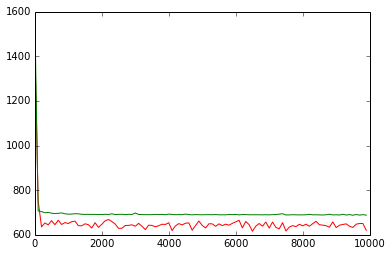

In [10]:
# plot the training error and validation error
Xaxis = [x * 100 for x in range(training_iter/100)]
plt.plot(Xaxis, train_error, 'r',label='train error')
plt.plot(Xaxis, valid_error, 'g',label='validation error')
plt.show()

In [11]:
test_set1.shape

(10000, 46)

In [12]:
test_set2 = numpy.reshape(test_set1, (test_set1.shape[0]*2, test_set1.shape[1]/2))

In [13]:
# reshape the W matrix to [23,10]
W_1_prime = numpy.reshape(W_1,[23, n_hiddens[0]])
hidden_1 = sess.run(tf.nn.sigmoid(numpy.matmul(test_set2,W_1_prime)+b_1))
W_2_prime = numpy.reshape(W_2,[n_hiddens[0], n_hiddens[1]])
hidden_2 = sess.run(tf.nn.sigmoid(numpy.matmul(hidden_1,W_2_prime)+b_2))
W_3_prime = numpy.reshape(W_3,[n_hiddens[1], n_hiddens[2]])
hidden_3 = tf.nn.sigmoid(numpy.matmul(hidden_2,W_3_prime)+b_3)

In [14]:
test_features = sess.run(hidden_3)

In [15]:
test_features.shape

(20000, 50)

In [16]:
# evaluate function
def evaluateFunc(num, ori_set, new_set, nn, nNeighbor=100):
    '''
        num: the number of sample time series we use to evaluate the performance of our neural network model
        ori_set: it is the original dataset
        new_set: this is the dataset generated after we perform our neural network model on our original dataset
        nn: the number of time series we use to calculate the dtw and euclidean distance
        nNeighbor: the number of neighbors we extracted to compare the overlap between dtw and euclidean distances
    '''
    result = []
    for n in range(num):
        euclidean_dists = []
        dtw_dists = []
        for i in range(nn):
            dtw_dists.append((i,dtw(ori_set[i], ori_set[nn + n])))
            euclidean_dists.append((i, euclideanDist(new_set[i], new_set[nn + n])))
        euclidean_dists_sorted = sorted(euclidean_dists, key=(lambda x: x[1]))
        dtw_dists_sorted = sorted(dtw_dists, key=(lambda x: x[1]))
        euclid_set = set()
        dtw_set = set()
        for i in range(nNeighbor):
            euclid_set.add(euclidean_dists_sorted[i][0])
            dtw_set.add(dtw_dists_sorted[i][0])
        count = 0
        for x in euclid_set:
            if x in dtw_set:
                count += 1
        result.append(float(count)/nNeighbor)
    return reduce(lambda x, y: x + y, result)/len(result)

In [17]:
perform = evaluateFunc(1000, test_set2, test_features, 1000)

In [18]:
print perform

0.47119


In [ ]:
# with hidden layers defined as [100, 50], we get around 53.984% overlapping
# with hidden layers defined as [100, 23], we get around 40.405%
# with hidden layers defined as [100, 50, 23], we get around 40.646% overlapping